#### Prepared by: Yerbol Aussat
#### CS-889. University of Waterloo


# K-Curvature Finger Tracking


In [131]:
# Import necessary libraries and helper functions
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from helpers import imshow

In [132]:
# Method that generates mask that segments out skin regions 
def segment_skin_hsv(img):
    # Convert image to HSV
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

    # define range of hsv (for skin color)
    min_HSV = np.array([0, 58, 30], dtype = "uint8")
    max_HSV = np.array([33, 255, 255], dtype = "uint8")

    # create a mask and clean it up
    mask = cv2.inRange(hsv, min_HSV, max_HSV)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, None, iterations = 5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, None, iterations = 5)
    mask = cv2.medianBlur(mask, 5)   
    
    return mask

In [134]:
def getHandContours(mask):
    # Get the contour of the hand and draw it on the original image
    im2, contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Calculate areas
    areas = [cv2.contourArea(cont) for cont in contours]
    
    # Only keep the largest contour
    if len(contours) == 0:
        return
    cnt = contours[np.argmax(areas)]
    return cnt

## Note: CHAIN_APPROX_SIMPLE parameter of findContours method doesn't return uniformly spaced points

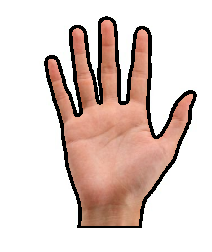

5388


In [135]:
# Import the original image
img = cv2.imread('palm2.jpg')

mask = segment_skin_hsv(img) # Mask that segments skin regions
cnt = getHandContours(mask) # Hand Contour

# Draw contour
for index in range(len(cnt)):
    cv2.circle(img, tuple(cnt[index][0]), 1, (0, 0, 0), 15)    

imshow(img)
# cv2.imshow("Image", img)
# cv2.waitKey()
# cv2.destroyAllWindows()

## Smoothening Contours and Downsampling

In [62]:
from scipy.interpolate import splprep, splev

# Helper method that smoothens the contor and downsamples the number of points 
# in the new contour to n
def smoothenContour(cnt, n):
    x,y = cnt.T
    # Convert from numpy arrays to normal arrays
    x = x.tolist()[0]
    y = y.tolist()[0]
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
    tck, u = splprep([x,y], u=None, s=1.0, per=1)
    # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
    u_new = np.linspace(u.min(), u.max(), n)
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
    x_new, y_new = splev(u_new, tck, der=0)
    # Convert it back to numpy format for opencv to be able to display it
    res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
    return np.asarray(res_array, dtype=np.int32)

In [63]:
# Import the original image
def getSmoothenedCnt(img):
    mask = segment_skin_hsv(img) # Mask that segments skin regions
    cnt = getHandContours(mask) # Hand Contour

#     cnt = smoothenContour(cnt, 1000)
#     # Draw contour
#     for index in range(len(cnt)):
#         cv2.circle(img, tuple(cnt[index][0]), 1, (0, 0, 0), 15)    
    return cnt


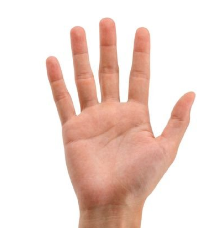

In [77]:
img = cv2.imread('palm2.jpg')
cnt = getSmoothenedCnt(img)
imshow(img)

## Now we are ready to apply k-Curvature algorithm 
   ###  Take k = 3 and threshold angle = 60

In [78]:
k = 35
thresh_angle = 75

In [79]:
# Helper function to find angle between two vectors
def get_angle(v1, v2):
    v1 = v1 / np.linalg.norm(v1) # unit vector v1
    v2 = v2 / np.linalg.norm(v2) # unit vector v2
    cos_theta = np.dot(v1, v2) 
    return np.arccos(cos_theta)*(180/np.pi)

# Helper function to find distance between two vectors
def dist(v1, v2):
    return np.linalg.norm(np.array(v1)-v2)

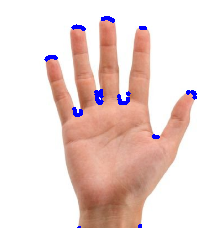

In [80]:
img = cv2.imread('palm2.jpg')
cnt = getSmoothenedCnt(img)

for j in range(len(cnt)):
        
    # determine points corresponding to indices j-k, j and j+k
    pointJ = cnt[j][0]
    minusK = cnt[(j-k)%len(cnt)][0]
    plusK = cnt[(j+k)%len(cnt)][0]
    
    angle = get_angle(minusK - pointJ, plusK - pointJ)
        
    if angle <= thresh_angle:
        cv2.circle(img, tuple(pointJ), 1, (255, 0, 0), 20)
imshow(img)

# Implement two tweaks:
### 1) To differentiate between the space between fingers and the fingertips find cross product
### 2) Out of neighboring points that satisfy the threshold take the one with the lowest k-curvature 

In [81]:
# # Helper function that updates an array of stored points, corresponding to 
# # valleys or peaks)
# pointDict: {index -> k_curv}

def update(pointDict, j, kCurv):
    
    for i in pointDict:
        
        # if index j is close to one of the stored indices 
        if abs(i-j) <= 50 or abs(i-j) >= len(cnt)-50:
            
            # if k-curvature of point j is smaller, replace i by it
            if kCurv < pointDict[i]:
                pointDict[j] = kCurv
                del pointDict[i]
            return pointDict                        
    pointDict[j] = kCurv
    return pointDict

In [99]:
img = cv2.imread('palm2.jpg')
getSmoothenedCnt(img)

peaks = {} # Array that stores points corresponding to fingertips
valleys = {} # Array that stores points corresponding to spaces

for j in range(len(cnt)):
    
    # determine points corresponding to indices j-k, j and j+k
    jCoord = cnt[j][0]
    minusK = cnt[(j-k)%len(cnt)][0]
    plusK = cnt[(j+k)%len(cnt)][0]
        
    kCurv = get_angle(minusK - jCoord, plusK - jCoord)
    
    if kCurv <= thresh_angle:
                
        orientation = np.cross(minusK - jCoord, plusK - jCoord)
        
        if orientation >= 0:
            peaks = update(peaks, j, kCurv)
        else:
            valleys = update(valleys, j, kCurv)

4
{552: 55.60862795046792, 1612: 70.039570319446227, 1814: 25.209043580389729, 1305: 52.818112943453571, 220: 45.39830185907666, 925: 72.165395004930474}


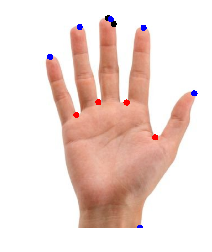

In [91]:
# Draw valleys as red circles
print len(valleys)
print peaks


for j in valleys:
    jCoord = cnt[j][0]
    cv2.circle(img, tuple(jCoord), 1, (0, 0, 255), 30)
    
# Draw peaks as blue circles
for j in peaks:
    jCoord = cnt[j][0]
    cv2.circle(img, tuple(jCoord), 1, (255, 0, 0), 30)
imshow(img)

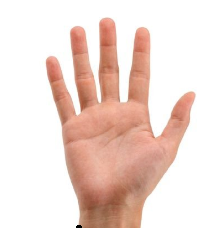

In [113]:
img = cv2.imread('palm2.jpg')
getSmoothenedCnt(img)

jCoord = cnt[924][0]

cv2.circle(img, tuple(jCoord), 1, (0, 0, 0), 30)
# cv2.circle(img, tuple((cnt[925+30][0])%len(cnt)), 1, (0, 0, 0), 30)
# cv2.circle(img, tuple(cnt[925-30][0]), 1, (0, 0, 0), 30)


imshow(img)
